In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/tess-dataset/train-00000-of-00008


In [2]:
!pip install lightkurve

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.6/247.6 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.5/4.5 MB 50.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 kB 3.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... - done
  Preparing metadata (setup.py) ... - done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 832.7/832.7 kB 38.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.9/48.9 kB 3.2 MB/s eta 0:00:00
  Created wheel for memoization: filename=memoization-0.4.0-py3-none-any.whl size=50467 sha256=339416671c9282506ea0ddf8826a93cdbc7fb8beed32706c36ae92cc0b6b8fa0
  Stored in directory: /root/.cache/pip/wheels/38/f7/65/161985e7311dd484a23b3a5c9149995dbf11db6cede602e7ef
  Created wheel for oktopus: filename=oktopus-0.1.2-py3-none-any.whl size=12779 sha256=bae5b0c68b7623d00f443fb4f55ffbd347ddfb01e257cad89f3df4faa4753213
  Stored i

In [3]:
import lightkurve as lk
import tensorflow as tf

In [4]:
result=lk.search_targetpixelfile('Pi Mensae', mission='TESS', sector=1)
result

SearchResult containing 2 data products.

 #     mission     year   author  exptime target_name distance
                                     s                 arcsec 
--- -------------- ---- --------- ------- ----------- --------
  0 TESS Sector 01 2018      SPOC     120   261136679      0.0
  1 TESS Sector 01 2018 TESS-SPOC    1800   261136679      0.0

In [5]:
#Tess Target Pixelfile
ttp = result.download(quality_bitmask='default')

/opt/conda/lib/python3.7/site-packages/lightkurve/search.py:352: LightkurveWarning: Warning: 2 files available to download. Only the first file has been downloaded. Please use `download_all()` or specify additional criteria (e.g. quarter, campaign, or sector) to limit your search.
  LightkurveWarning,
9% (1797/20076) of the cadences will be ignored due to the quality mask (quality_bitmask=175).


In [6]:
ttp

TessTargetPixelFile(TICID: 261136679)

In [7]:
ttp.camera

4

In [8]:
ttp.ccd

2

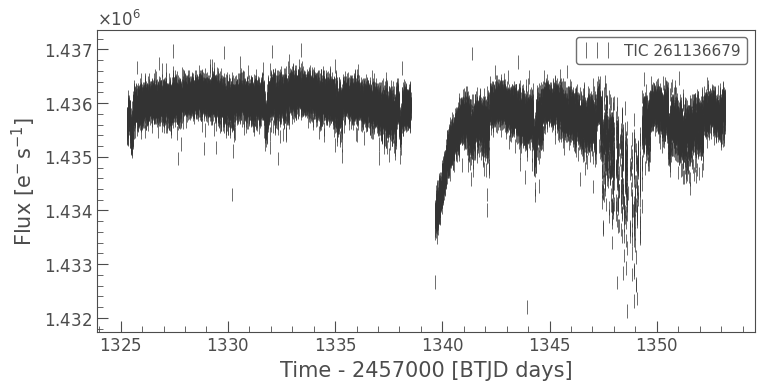

In [9]:
light_curve=ttp.to_lightcurve()
light_curve.errorbar();

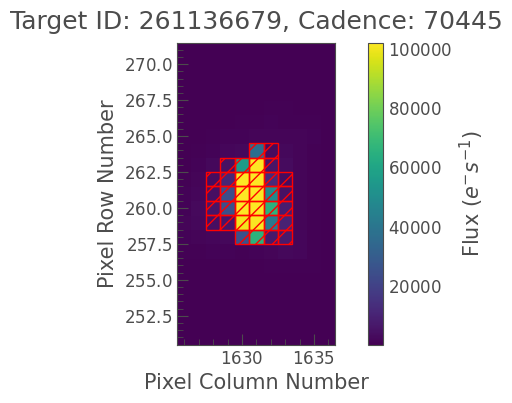

In [10]:
ttp_aperture_mask=ttp.create_threshold_mask(threshold=10)
#Plot that aperture
ttp.plot(aperture_mask=ttp_aperture_mask);

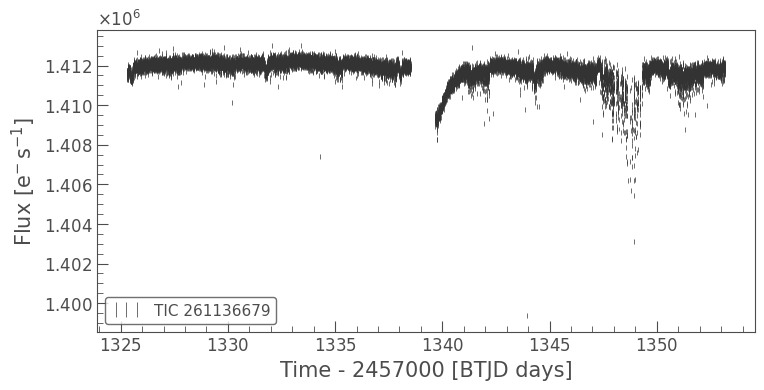

In [11]:
light_curve=ttp.to_lightcurve(aperture_mask=ttp_aperture_mask)
light_curve.errorbar();

In [12]:
print(light_curve.time.shape)

(18279,)


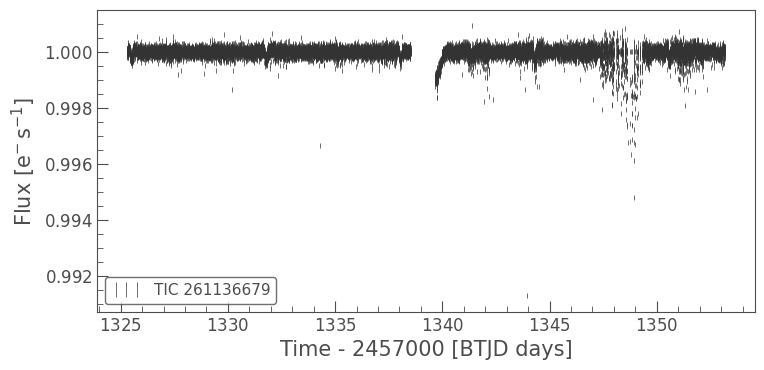

In [13]:
flat_light_curve=light_curve.flatten(window_length=1001)
flat_light_curve.errorbar();

In [14]:
#The light curve looks much flatter. Unfortunately there is a portion of the light curve that is very noisy, due to a jitter in the TESS spacecraft. We can remove this simply by masking the light curve. First we’ll select the times that had the jitter.
mask=(flat_light_curve.time.value<1346) | (flat_light_curve.time.value>1350)

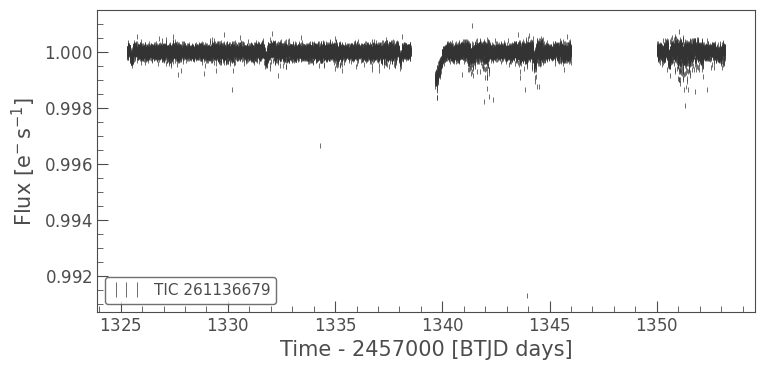

In [15]:
masked_light_curve =flat_light_curve[mask]
masked_light_curve.errorbar();

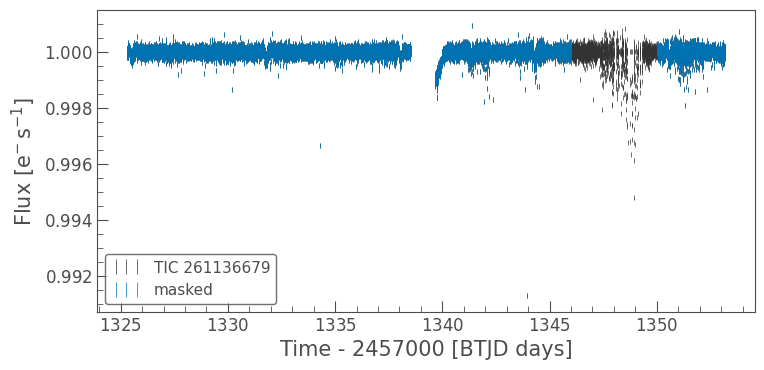

In [16]:
axes=flat_light_curve.errorbar()

#Pass the above axes to next plot
masked_light_curve.errorbar(ax=axes,label='masked');

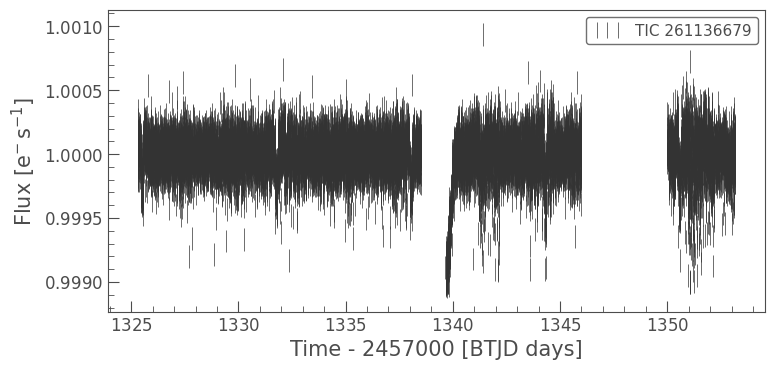

In [17]:
clipped_light_curve=masked_light_curve.remove_outliers(sigma=6)
clipped_light_curve.errorbar();

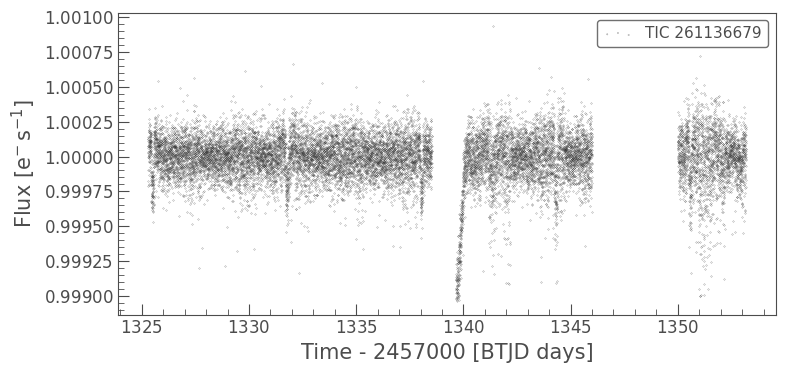

In [18]:
#This works same as matplotlib.pyplot.scattr 
clipped_light_curve.scatter(s=0.1);

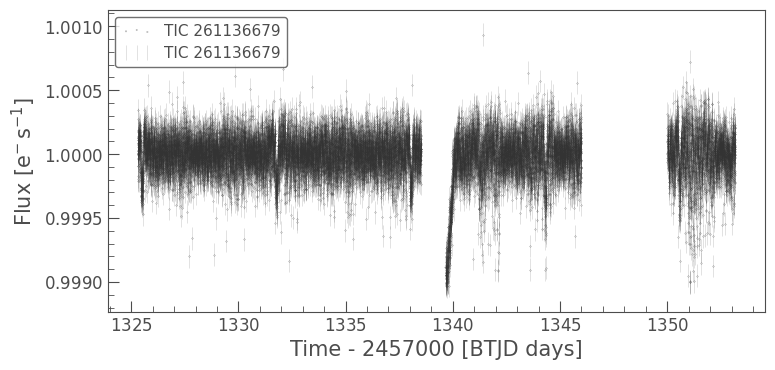

In [19]:
axes=clipped_light_curve.scatter(s=0.1)
clipped_light_curve.errorbar(ax=axes,alpha=0.2); #alpha determines transparency

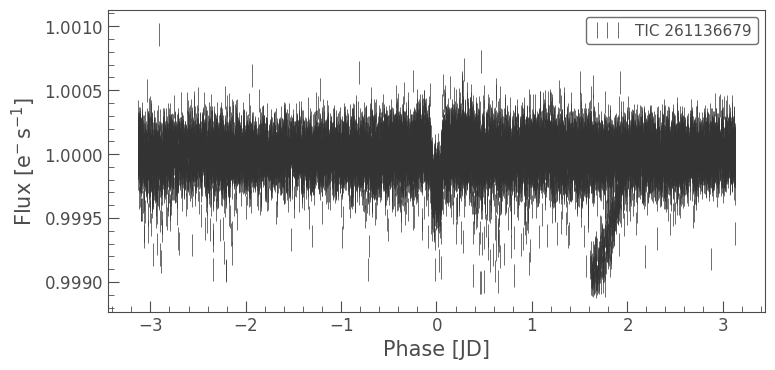

In [20]:
#Finally let’s use lightkurve to fold the data at the exoplanet orbital period and see if we can see the transit.
folded_light_curve=clipped_light_curve.fold(period=6.27, epoch_time=1325.504)
folded_light_curve.errorbar();

In [21]:
!pip install astropy

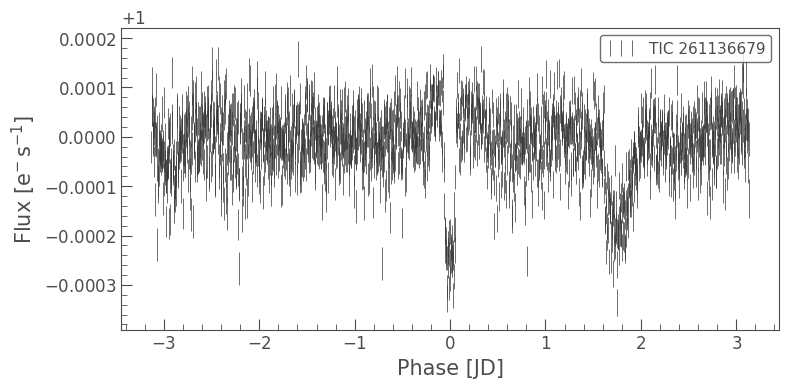

In [22]:
#It looks like there’s something there, but it’s hard to see. Let’s bin the light curve to reduce the number of points, but also reduce the uncertainty of those points.

import astropy.units as un
binned_light_curve=folded_light_curve.bin(time_bin_size=5*un.minute)
binned_light_curve.errorbar();